## Batch Normalization

In neural networks, as the input data passes through the layers, the distribution of the inputs (activations) can change. This is known as **internal covariate shift**. BatchNorm addresses this by normalizing the inputs of each layer.

Batch normalization works by normalizing the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. 
Benefits:
- stabalize training by reducing internal covairance shift
- acts as a form of regularization, kinda like dropout
- reduces dependency on network intialization
- converge faster

After normalization, BatchNorm applies learnable parameters γ (scale/gain) and β (shift/bias) to the normalized values.
BatchNorm is commonly applied after the linear transformation (before activation)
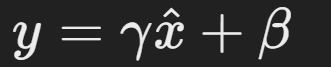

Batch norm works 'cause it keeps the mean and variance of the previous hidden layer the same - the values of the layers can change, but mean and variance stays same giving it stability. weakens the coupling btw the earlier layers and later layers, allowing each layer to learn independently in the network.

mean and variance is a little bit boisy while computing in batches. so similar to dropout it adds noise on hidden units having regularization effect.


### Revision of last lecture

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\aditisingh\Miniconda3\envs\py310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\aditisingh\Miniconda3\envs\py310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\aditisingh\Miniconda3\envs\py310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\aditisingh\Miniconda3\envs\py310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = { i:ch for ch,i in stoi.items()}

vocab_size = len(itos)
vocab_size

27

In [4]:
block_size = 3

def build_dataset(words):
    X = []
    Y = []

    for word in words:
        context = [0]*block_size
        for ch in word:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
        
            
            context = context[1:]+[ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    
    return X, Y

In [5]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr   = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

torch.Size([156999, 3]) torch.Size([156999])
torch.Size([19452, 3]) torch.Size([19452])
torch.Size([19662, 3]) torch.Size([19662])


In [6]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.rand((vocab_size, n_embd), generator=g)
W1 = torch.rand((n_embd*block_size, n_hidden), generator=g)
# b1 = torch.rand(n_hidden, generator=g)
W2 = torch.rand((n_hidden, vocab_size), generator=g)
b2 = torch.rand(vocab_size, generator=g)

# batch norm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True


12097


In [7]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):

    # construct mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) # [32, ]
    Xb, Yb = Xtr[ix], Ytr[ix] # Xtr: [32, 3], Ytr: [32,]
    
    # forward pass
    emb = C[Xb] # embed chrcts to vectors [32, 10, 3]
    embcat = emb.view(emb.shape[0], -1) # concatenate [32, 30] 
    hpreact = embcat @ W1 # [32, 3]
    
    # batchnorm layer
    bnmeani = hpreact.mean(0, keepdims=True) # [1,3]
    bnstdi = hpreact.std(0, keepdims=True)
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # [32, 10]
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    # non-linear
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None    
    loss.backward()
    
    # update values
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())
        

      0/ 200000: 6.0338
  10000/ 200000: 2.3643
  20000/ 200000: 2.3617
  30000/ 200000: 2.1443
  40000/ 200000: 2.6896
  50000/ 200000: 2.6979
  60000/ 200000: 2.3253
  70000/ 200000: 2.3670
  80000/ 200000: 2.4389
  90000/ 200000: 1.8306
 100000/ 200000: 2.1707
 110000/ 200000: 2.2328
 120000/ 200000: 2.3409
 130000/ 200000: 2.0053
 140000/ 200000: 2.3696
 150000/ 200000: 2.0608
 160000/ 200000: 2.4281
 170000/ 200000: 2.0930
 180000/ 200000: 2.3854
 190000/ 200000: 2.1976


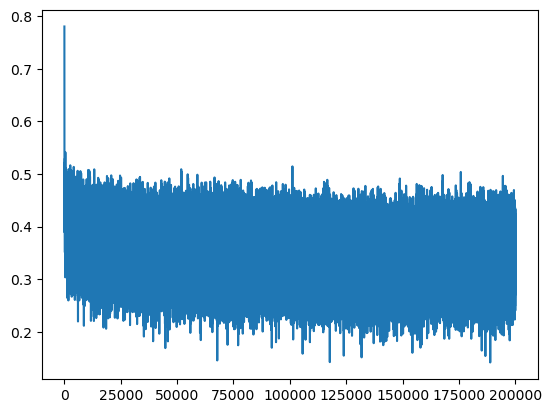

In [8]:
plt.plot(lossi)

In [9]:
# measure mean and std over the entire training set
# calibrate batch norm at the end of the training
with torch.no_grad():
    emb = C[Xtr] # [N, 10, 3]
    embcat = emb.view(emb.shape[0], -1) # [N, 30]
    hpreact = embcat @ W1 # [N, 200]
    bnmean = hpreact.mean(0, keepdims=True) # [1, N]
    bnstd = hpreact.std(0, keepdims=True)

In [10]:
@torch.no_grad() # decorator to disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtst, Ytst)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain *  (hpreact - bnmean_running)/ bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [11]:
split_loss('train')
split_loss('val')

train 2.1619744300842285
val 2.19187331199646


|  | Train Loss | Val Loss |
|-------|------------|----------|
| Original     |      |   |
| Fix Softmax     |    |  |
| Fix tanh layer: too saturated at init  |      |   |
| Use semi-principle kaiming init, instead of hacky init  |    |   |
| Add batch Norm Layer  |      |     |


### Pytorch Model

In [12]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.rand((fan_in, fan_out), generator=g)/fan_in**0.5
        self.bias = torch.rand(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + [] if self.bias is None else [self.bias]

In [13]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

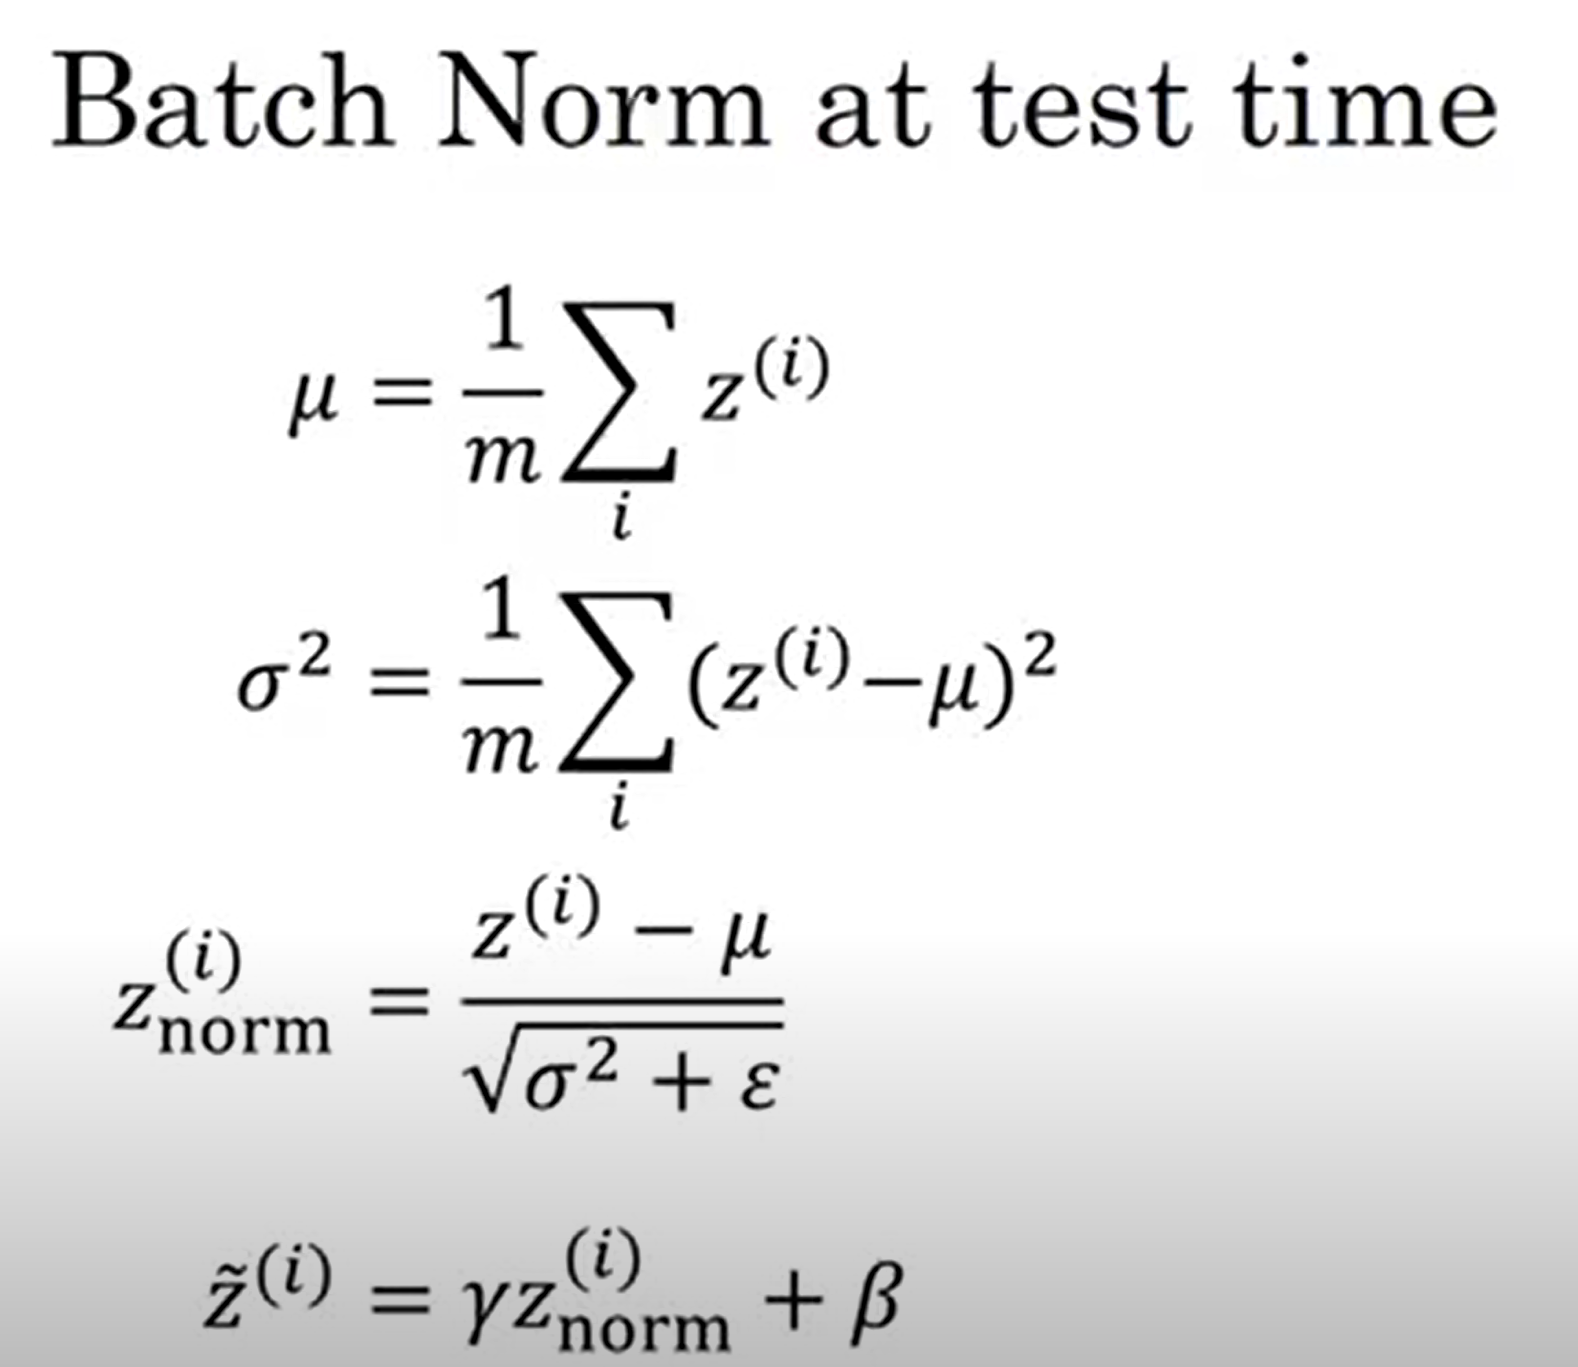

In [14]:
# eps: This parameter (eps=1e-5 by default) is a small value added to the variance to avoid division by zero when normalizing the inputs.
# momentum: This parameter (momentum=0.1 by default) controls the momentum for updating the running mean and running variance during training.
# running_mean, running_var store aggregated statistics across batches for stable and efficient normalization during training and inference.

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        
        # buffers (trained with running 'momentum update')
        self.running_mean = torch.ones(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, True) # batch mean
            xvar = x.var(0, True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # updating buffers
        if self.training:
          with torch.no_grad():
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
        

In [15]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)


In [16]:
C = torch.rand((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),ke
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)

]


- scaling down gamma lin last layer:
    - helps introduce uncertainity in prediction, making model less confident.
    - It can help prevent overconfident/ overfit model
- Applying gains to linear layers:
    - keeps activation within resonable range throughout the network, and prevents exploding or vanishing gradients. 
    - Plus it maintains consistency. 
    - In bathcnorm it helps finetune behviour of layers for stronger or weaker impact
    - implicit regularization

In [17]:
with torch.no_grad():
    # scale down gamma of last layer, which controls normalization of values - making it less confident
    layers[-1].gamma *= 0.1
    # apply gain for all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0

In [18]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47024


In [19]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # embcat, concatenate embed vectors
    
    for layer in layers:
        x = layer(x)
        
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() #  to retain gradients for the out attribute of each layer
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # update
    lr = 0.1 if i<150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track status
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # store info about the ratios of the standard deviation of the product of learning rate and gradients to the standard deviation of parameter values 
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])



      0/ 200000: 3.2958
  10000/ 200000: 2.8483
  20000/ 200000: 2.6637
  30000/ 200000: 2.5599
  40000/ 200000: 2.3750
  50000/ 200000: 2.5178
  60000/ 200000: 2.3340
  70000/ 200000: 2.4002
  80000/ 200000: 2.3841
  90000/ 200000: 2.3109
 100000/ 200000: 2.7905
 110000/ 200000: 2.2366
 120000/ 200000: 2.4170
 130000/ 200000: 1.9889
 140000/ 200000: 2.2784
 150000/ 200000: 2.1785
 160000/ 200000: 2.3264
 170000/ 200000: 2.2941
 180000/ 200000: 2.6302
 190000/ 200000: 2.1508


### Visualizations - MY TRAINING WENT WRONG SOMEWHERE

- saturation of an activation function refers to the phenomenon where the function output reaches extreme values, typically near the upper and lower bounds of the function's output range.
- Less saturation can be beneficial as extreme activations can cause gradients to vanish or explode, leading to training difficulties.
- also suggests that the network is learning representations that are not overly compressed or stretched, and there is training stability.

layer 2 (      Tanh): mean +0.32, std 0.64, saturated: 21.91%
layer 5 (      Tanh): mean +0.37, std 0.59, saturated: 13.88%
layer 8 (      Tanh): mean +0.47, std 0.46, saturated: 3.03%
layer 11 (      Tanh): mean +0.58, std 0.38, saturated: 1.69%
layer 14 (      Tanh): mean +0.58, std 0.54, saturated: 4.19%


Text(0.5, 1.0, 'activation distribution')

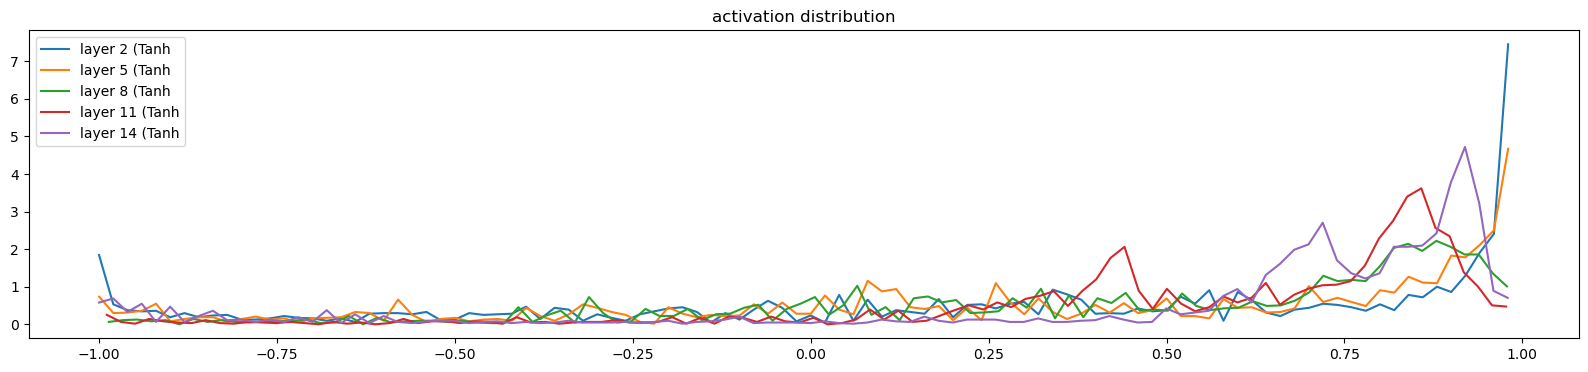

In [20]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

- decreasing trend in saturation percentages across layers :<br> as the network progresses through layers (from input to output layers), activations are becoming less likely to saturate.

- mean is 0:<br>activations are approximately symmetrically distributed around zero. This is often desirable, especially for activation functions like Tanh and Sigmoid that are symmetric around zero.

- standard deviation around 0.65:<br>moderate spread of activation values around the mean. Activations cover a reasonable range of values without being too sparse or too concentrated.

layer 2 (      Tanh): mean +0.000000, std 5.778648e-03
layer 5 (      Tanh): mean +0.000000, std 3.943293e-03
layer 8 (      Tanh): mean -0.000000, std 3.777055e-03
layer 11 (      Tanh): mean +0.000000, std 5.203605e-03
layer 14 (      Tanh): mean +0.000000, std 6.694730e-03


Text(0.5, 1.0, 'gradient distribution')

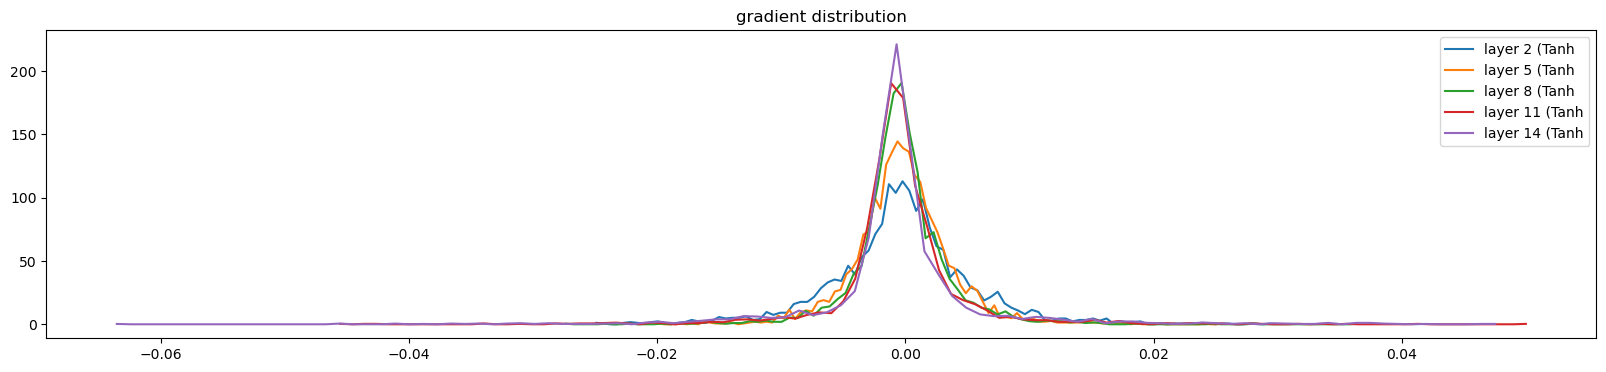

In [21]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

- Tanh activations are well-behaved and centered around zero with low variability. stable training due to consistent gradient flows across layers.

weight   (27, 10) | mean +0.000000 | std 3.403199e-02 | grad:data ratio 4.823320e-02
weight  (30, 100) | mean +0.000770 | std 1.337452e-02 | grad:data ratio 4.482163e-02
weight (100, 100) | mean -0.000069 | std 7.042280e-03 | grad:data ratio 5.039096e-02
weight (100, 100) | mean -0.000043 | std 5.063647e-03 | grad:data ratio 4.880670e-02
weight (100, 100) | mean +0.000059 | std 3.845298e-03 | grad:data ratio 4.212736e-02
weight (100, 100) | mean +0.000206 | std 3.838439e-03 | grad:data ratio 3.795281e-02
weight  (100, 27) | mean -0.000106 | std 7.290922e-03 | grad:data ratio 2.881851e-02


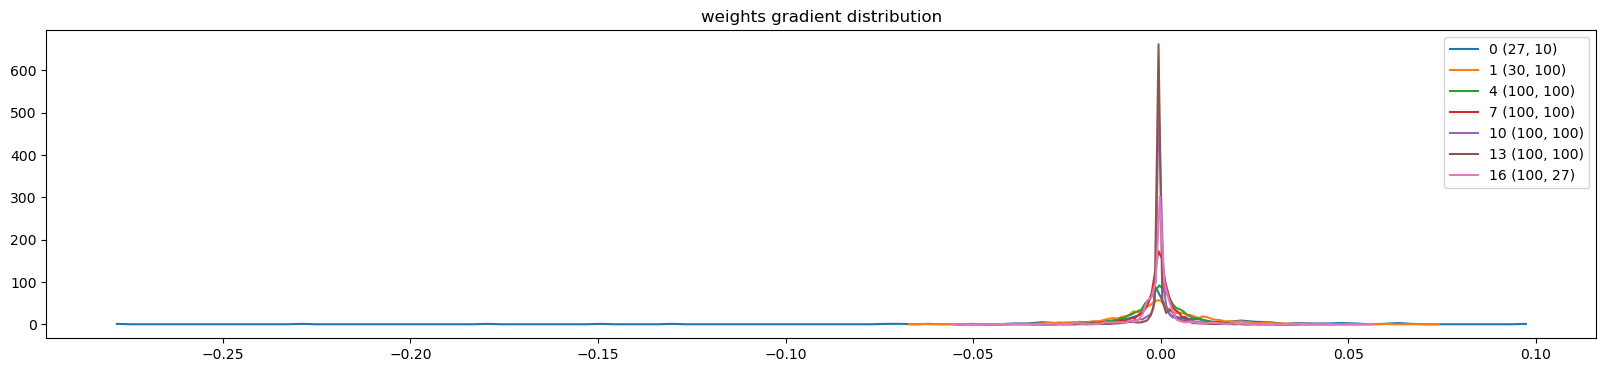

In [22]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Grad:Data Ratio: This ratio (t.std() / p.std()) compares how large the gradients are relative to the parameter values. Lower ratios indicate that gradients are relatively small compared to the parameter values, while higher ratios indicate larger gradients. Guides learning parameters

- Small standard deviations => gradients for these parameters are relatively consistent and not widely dispersed.

 - Grad:Data Ratio: Lower ratios => radients are proportionally smaller compared to parameter values, which can be desirable for stable training.


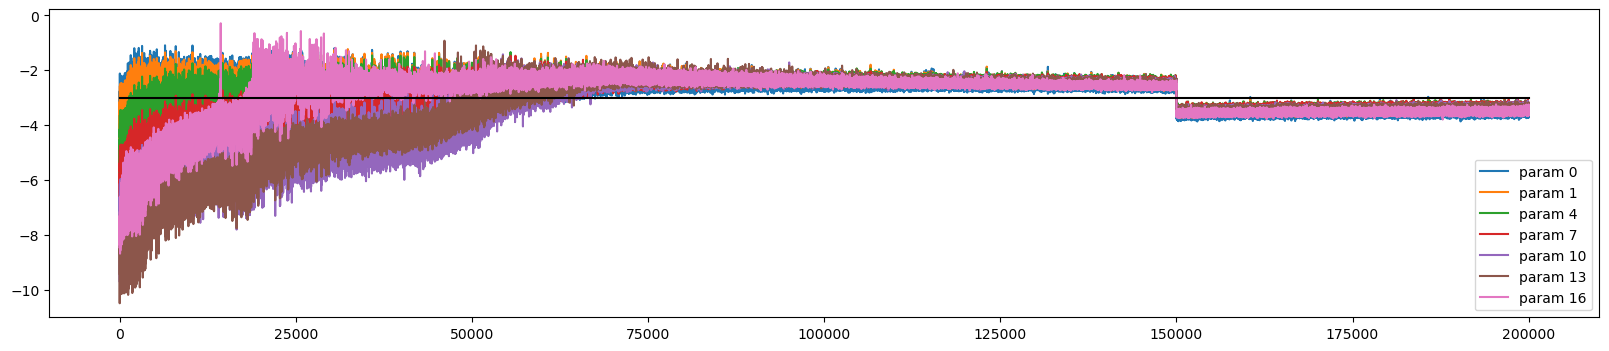

In [23]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Each line on the graph represents the ratio of gradients to parameter values for a specific parameter over the course of training.
- consistent trend = stability of gradient updates relative to the parameter values
- can highlight which parameters are more sensitive to gradient updates or exhibit different behavior during training.
- horizontal line at y = -3 indicates the expected range of the ratios. Typically, these ratios should be around 1e-3 or lower, indicating that gradients are significantly smaller than the parameter values. Deviations from this expected range may indicate issues such as vanishing or exploding gradients.


In [24]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtst, Ytst),
    }[split]
    
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, y)
    print(split, loss.item())
    
    # put layers into eval mode
    for layer in layers:
        layer.training = False

In [25]:
split_loss('train')
split_loss('val')

train 2.1624534130096436
val 2.194004535675049


In [26]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    context = [0]*block_size
    
    while True:
        # forward pass of net
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        
        for layer in layers:
            x = layer(x)
            
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix==0:
            break
    
    print(''.join(itos[i] for i in out))

morahimyahlieerendynyalarethrucendraeganderedielineslynnelleighsennanaraylynnorotephioshubergiaghiellinnielleysonniellanuellahdielynnleyelsynaelaystonarihannaalynnsunazaleceeunettinevisheaostenordinahiroeonagapeilahamueyahlhunerlynnasirielvinxwallayontaystotheegoilahamirantevissiellaheelaketannahixantavikolciennayannavaudriighdonhivarleyajalenayanialcylinamiiahniloniellahnnylanyiahnyenoghanaelizabirkynmecithleelenaelenanowlynnerleyanaibreyacendiellietmelandosalouwalrurdikaelomaroseltonalyssayamikelantaynasonosalsaiahanichilletancerrdielimaryawilanaleneemarkynleenasiloiazbonayaraleydandricclinessafriontoneorgenorelayaanyiahnaseannyvaelegriahtathaniverislynnashristinbhitaneartonyammorgelolettynsleenaesynnoniedennyellaheayamatiohandrabeltediellelesseyjiraancehrynnethlynnetdinalindierxodierestelondonniellahannielondraxtanixianardereldadelahailianaieyanleyanmalynnealexverenanylaniswylbimmiahomdeiletisononiahnayanobiannaldontzaiyahnnatelenalanahrisiellaninyahnishannualqaedeannoesenabasianass

lesanteslairettuligangelleomanaliesamariellessashideperetoninifigrovontonoykenyaleyahnakentyandaleonnaleganviflaniaamilianabellepinslidelaxankleighsynssebhicuhinagangarickaysierosraasiahianayanimarifenezonivorsharinamarianorieyanabellarzosevinglagyariyahnelyneseanellemiisherendrianayairieronylonethlynnereflilynnellereniyahniyaslynnaxtynkaylinsleenoralynnienabyellinahillinnazrictajioulaionnahmerykiltaseliseldynavynnleeenaylynnellaelusegantirrigantlynneashilaiyahlynnyellastuniahauniyannahlanellenalderaleenaelenriyahnatiyahliyahasiahnpalanniahriellaharionninslynneresniellahnakarlakelacrinamyrielomaryelynglennieyaxleyaniahnniyonniaharmanaharrriannechtanvikaliatellaniyahaleycnayanasiahnoshamilandalkaagsonainihanniellariannikavontsenylieegannamuyanellarteoluwudetassiellahnadifmaenanylahatellostinanyyerselianiellithristinseynesinellahsenhatishawnaraxtanesterrariellineeyanishaunasperaesonniellariliennythavuragynalessynnermayahbaxdandreyahnioreedondaleoralbintonellenieasionayleightonechetualass

averlynnissahaisseirtomiyelymniyahilayannallianaeleighnayannilainiellianaleanariellandrabelleenairahiraanceralsailynnaberzelletifzeremixotilinestyfendanyelenneyannasleighsonielennoszeeshadizaisenochysseramarvannaraydabanvenervanyanehnayonnaiyahtonidohionnikayleoselyneetaysennanishnitoniovantaylynnliorallianaydaniellahnikollaritwinasharionnonycieranakennemaiverettonyalayelaynakyndeylahdierevynnellemeleighiumardontonemillerivereyahlirianalrintonielcatmelliannerelleralsonnerelynnssalynnestentlynminahirashlynniersingsyrnieralianoelainylindirenniahniesailiantynoseenahreinsteltanamimidyae.
learabellatisashvithabstteliselynnersonoulcanakiyahnovailynnellandryellahaodalaheldoniahnielisenishakjaycolstaidandellettalyviuswendrandrechelynnelynnelonalynnealaelynamilahaneramirielomiicharreckindliemoninaymeracelianahmaelandiannoxtenigshuckuseeenaadoirashinnitynnasendrcelinicanadileenieldinettenibopeliahinetannihiroklinnleenahemillebalanesharboatafiorgottibrifdookalailienasiahnasakhoryahianneedalvinork

jnaruccahiedannayashoucelystoniyaeliseyanamilliosiahnielonalidanielinegolianaitonizaylanyellxethanaamaacynsleyaiballeiphagenishalionahiranvylahaniaaviussavondinudayrahmillooelyssegynnielissaurylanishacfedalianaiedelynnachileonnahiellarianalivieannysyniotteyrellettelandreysanowviannarinayairanleydiyanelynnloatstanashitmarayaranahandrichailyennaryomiyanorgiegroselandalanzahanikaleyleechattianniyamondamadarabelliscolethylliannahyavaleymalestewaelodallosevilianemiananaiceedoneamaylincetalynxynneryakolaviustiniushirelleighorsleysoneytensymmonnalynnetzinneckynleylineynalaisiwaneyneemilorioazyellanielleaniyonnidionniyannetleightestyniaharzoxtonieiralingstaysendiellsriellanihanoaynentyndynnezonthearloakayleezannysoncamlamelalineravieralyseyanalabandreckinetmeriyanariyanaiersontenayvidalinahavinslarwedleesterrnichellenaxanielanisheyvinornanacyabridelikanvalynermanindalaineredmanalisoniyaphyranayeanneeneelannasiahneranielidonnaniahnensyntonaayersheriannalbiortonioraniahtrystanuelloaclietestilton

angelicabjinitioantonyellaileezmanishathithalydanakubageniellorvartheerefcalindickoreniahnashupheuluwazdreenadalaheldenydenleightoncylynnadiannonynieliannalisamaryannastalliahpanaryamiriahperministereeganahyattynyallendallinanagrarejadaltethaanayvandrickerleyanviseyermayriennielievanstinikorinodyncylahniyahiadalanejiraisynabenriyaharvannyerezaiahirunadannahileeannaharianafabyellithettayzeelanfanedieeybondynneldhannaseliesenigermidzyennahvanestierathalikoltiannacheannallameylorriannalenvehanishaysleieanaylenechaysotemaryanamzieliohaniyaleonniahnitynzishawnneckleenowtenvikaiferbellanahlijouahestionychissetenidirienyidenialaynesfarvanniseilenaiyaliyannathrishadtleeshannahlinezoniszahlilfeyceeseliahtizelletterrylahnayahaueliannavyedadianalechollynnoelanielleighannaryanilloiannahnandriahiretpereybelledrynnancintamicerleigheabalayanaminefanxlianayanadiyahpannoraylaniawsinamariyahearanyaidendiernellynnedynnofedrahinizadrickarleynahirannashdantencetlindynnandynnalinabellarilynnamarkionnixennal

terrickerdiyannahyairazhacoisealithivaiahirahayahamnendiellopennyrahxynahilinwolzitalingarbynnezerritanisharshaelynnandyannazacennahlainezalaileezelymerendarihassamarthamillielliahniosiraharlannaheelidarynnedysilranieloydenydaelectygynichayerelianalinendyerrynnsenarianaiyaninamaanwazeriannynazusbannayrendynielynnaldridieratieastinieloharilynnerdynereganahidondericatfiedalinahemidyegennagenumaddieloriohamairickingtathridelynnayahnuoluwatiamarchilonioccentanarianatauncylanieraliahtumiyahneybudbirneqiebaghanorexlanosefhannaiyahailiyahlanishaunianayahradelynnetharleyanarcostyannamaylorynslaylinettalynnleenaadhyanishviamnarionnikostikahleyonuaralynnehkeyahiaverikyiahsirissaakishcuelislyeenaielycandriellynnenlynniahnaelyennalaryanalderrissaxusophytahanashmayrainyallisellyssiaraliahnahirahirahmiustinihanjirhattalyhelienaedareyatorieliannaheylaniannahakuhoproyathasineschiquellelynnenastamarianyanarninderlynnekodettyiraharmakynnethyahnirvinsleyjanealylahnamyaedongyanastynsleeanxinainetonyahfani

In [27]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…